In [1]:
from IPython.core.debugger import set_trace
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import os
import time
from itertools import product
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import base
import numpy as np

In [2]:
item_categories = pd.read_csv('future-sales-data/item_categories.csv')
items           = pd.read_csv('future-sales-data/items.csv')
sales           = pd.read_csv('future-sales-data/sales_train.csv')
print(len(sales[sales.item_cnt_day<=0]))
print(len(sales[(sales.item_price>=100000)]))
print(len(sales[(sales.item_price<=0)]))

sales           = sales[(sales.item_cnt_day>0)&(sales.item_price<100000)&(sales.item_price>0)]
shops           = pd.read_csv('future-sales-data/shops.csv')
test            = pd.read_csv('future-sales-data/test.csv')

7356
1
1


# Visualize Total Sale During the Years

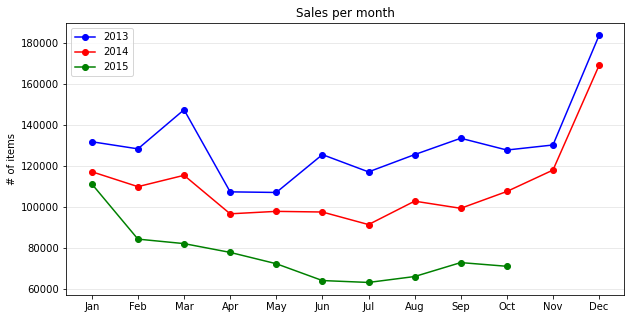

In [3]:
data = sales[['date', 'date_block_num','item_cnt_day']].copy()

# set_trace()
data['date']  = pd.to_datetime(data['date'], format='%d.%m.%Y')
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data.drop(['date'], axis=1, inplace=True)
data = data.groupby('date_block_num', as_index=False)\
           .agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'})\
           .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

plt.figure(figsize=(10,5))
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(MONTHS,data[data.year==2013]['item_cnt_month'],'-o',color='blue',label='2013')
plt.plot(MONTHS,data[data.year==2014]['item_cnt_month'],'-o',color='red',label='2014')
plt.plot(MONTHS[:10],data[data.year==2015]['item_cnt_month'],'-o',color='green',label='2015')
ax = plt.gca()
ax.set_title('Sales per month')
ax.set_ylabel('# of items')
ax.grid(axis='y', color='gray', alpha=.2)

plt.legend()
plt.show()

# Visualize Top Selling Items for each Year

2013: the total of the top 15 best selling items is 1304002 over a total of 1565895 for that year, which represents 83.28%
2014: the total of the top 15 best selling items is 1048377 over a total of 1323594 for that year, which represents 79.21%
2015: the total of the top 15 best selling items is 580259 over a total of 766256 for that year, which represents 75.73%


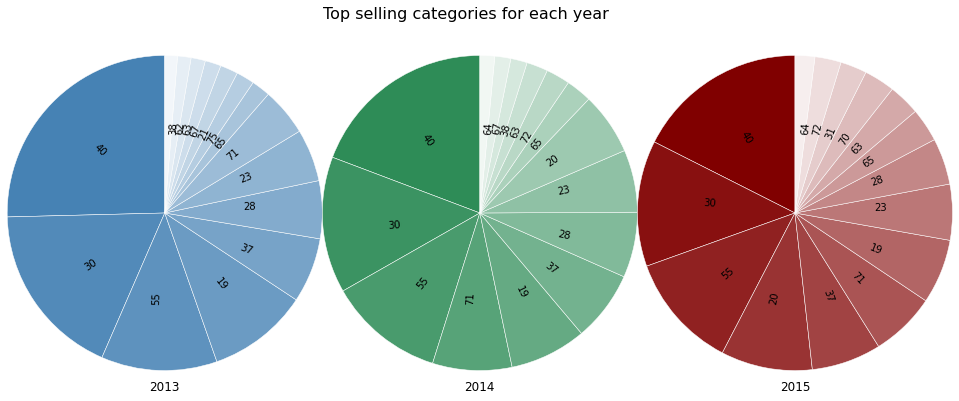

In [4]:
N=15
years = [2013, 2014, 2015]
fig, axes = plt.subplots(1, 3, figsize=(16,6))

def get_ratio(year, topn, N):
    # Get total sold items for each year
    total = data.loc[year].item_cnt_year.sum()
    ratio = topn/total*100
    return "{0}: the total of the top {1} best selling items is {2} over a total of {3} for that year, which represents {4:.2f}%".format(year, N, topn, total, ratio)


data = sales[['date', 'item_id', 'item_cnt_day']].copy()
data['year'] = pd.to_datetime(data['date'], format='%d.%m.%Y').dt.year
data.drop('date', axis=1, inplace=True)
data.item_cnt_day = data.item_cnt_day.astype(int)
data = data.merge(items[['item_id','item_category_id']], how='left', on='item_id')
data = data.groupby(['year', 'item_category_id'])\
       .agg({'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_year'}, inplace=False)


top=data['item_cnt_year'].groupby('year',group_keys=False).nlargest(N,keep='all')
top = pd.DataFrame(top).reset_index()

#Prepare colors for the top N
colors = [[] for i in range(3)]
for alpha in np.arange(N, 0, -1)/N:
    colors[0].append((.275, .51, .706, alpha))
    colors[1].append((.18, .55, .34, alpha))
    colors[2].append((.5, 0, 0, alpha))
    
for ax, year, cs in zip(axes, years, colors):
    # Get top items for each year
    year_filter = top[top.year==year]
    plot_sizes = year_filter.item_cnt_year
    plot_labels = year_filter.item_category_id
    
    # Get the ratio
    print(get_ratio(year, plot_sizes.sum(), N))
    
    # Plot the pie
    ax.pie(plot_sizes, labels=plot_labels, radius=1.5, colors=cs,labeldistance=.5, rotatelabels=True, startangle=90, wedgeprops={"edgecolor":"1",'linewidth': .5})
    # Set titles below pies
    ax.set_title(year, y=-0.2)

# Space pies
# fig.tight_layout()
fig.suptitle('Top selling categories for each year', fontsize=16)
plt.show()

del data

# Data Preprocessing

### Clean Shop Data:

In [5]:
# Clean shop data
shops= pd.read_csv('future-sales-data/shops.csv')
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'
shops["shop_city"] = shops.shop_name.str.split(' ').map(lambda x: x[0])
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.shop_city == "!Якутск", "shop_city"] = "Якутск"
shops["shop_city"] = LabelEncoder().fit_transform(shops.shop_city)
shops["shop_category"] = LabelEncoder().fit_transform(shops.shop_category)
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [6]:
# remove duplicate shops
# print(shops.sort_values(["shop_city","shop_category"]))
sales.loc[sales.shop_id==0, 'shop_id'] = 57
test.loc[test.shop_id==0, 'shop_id'] = 57

sales.loc[sales.shop_id==1, 'shop_id'] = 58
test.loc[test.shop_id==1, 'shop_id'] = 58

sales.loc[sales.shop_id==10, 'shop_id'] = 11
test.loc[test.shop_id==10, 'shop_id'] = 11

### Clean Category Data:

In [7]:
item_categories = pd.read_csv('future-sales-data/item_categories.csv')
item_categories["category_type"] = item_categories.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
# The category_type "Gamming" and "accesoires" becomes "Games"
item_categories.loc[(item_categories.category_type=="Игровые")|(item_categories.category_type=="Аксессуары"), "category_type"] = "Игры"
item_categories["split"] = item_categories.item_category_name.apply(lambda x: x.split("-"))
item_categories["category_subtype"] = item_categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

item_categories["category_type"] = LabelEncoder().fit_transform(item_categories.category_type)
item_categories["category_subtype"] = LabelEncoder().fit_transform(item_categories.category_subtype)
item_categories = item_categories[["item_category_id", "category_type", "category_subtype"]]

### Create feature vector:

In [8]:
# sum up the sales for each month
sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)\
          .agg({'item_cnt_day':'sum'})\
          .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

In [9]:
# Clip counts to remove outlier
sales['item_cnt_month'] = sales['item_cnt_month'].clip(0, 20)

# append the test data with date_block_num 34 (the next month) and sales 0 (default sale is 0)  to the historical monthly sales 
test['date_block_num'] = 34
test['item_cnt_month'] = 0
del test['ID']
df = sales.append(test)

# Add month to allow the model understand the seasoanlity
df['month'] = df.date_block_num%12
sales['month'] = sales.date_block_num%12



In [10]:
#  Create a Data Frame that contains all the possible combinations of (date_block_num, shop_id, item_id) 
#  and merge it with the monthly sales (df). Assign 0 for the entries that do not exist in monthly sales.

matrix = []
for num in df['date_block_num'].unique(): 
    tmp = df[df.date_block_num==num]
    matrix.append(np.array(list(product([num], tmp.shop_id.unique(), tmp.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=['date_block_num', 'shop_id', 'item_id'], dtype=np.int16)\
           .merge(df, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)

# df:        1822425 rows × 4 columns 
# matrix:    11098708 rows × 3 columns

In [11]:
#Merge features from shops, items and item_categories:

matrix = matrix.merge(shops, how='left', on='shop_id')
matrix = matrix.merge(items[['item_id','item_category_id']], how='left', on='item_id')
matrix = matrix.merge(item_categories, how='left', on='item_category_id')

In [12]:
# Create and merge shop sales, item sales, and category sales of each month

gb = matrix.groupby(['shop_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_shop'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

gb = matrix.groupby(['item_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_item'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

gb = matrix.groupby(['category_type', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_category'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['category_type', 'date_block_num']).fillna(0)

In [14]:
#Add lag features 

def lag_feature(df, lags, col):
    for i in lags:
        shifted = df[["date_block_num", "shop_id", "item_id", col]].copy()
        shifted.columns = ["date_block_num", "shop_id", "item_id", col+"_lag_"+str(i)]
        shifted.date_block_num += i
        df = df.merge(shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
    return df

matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'item_cnt_month')

matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_shop')
matrix.drop('cnt_block_shop', axis=1, inplace=True)

matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_item')
matrix.drop('cnt_block_item', axis=1, inplace=True)

matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_category')
matrix.drop('cnt_block_category', axis=1, inplace=True)


In [26]:
# encode categoriccal features according to their average monthly sales
def standard_mean_enc(df, col):
    mean_enc = df.groupby(col).agg({'item_cnt_month': 'mean'})
    scaler = StandardScaler().fit(mean_enc)
    return {v: k[0] for v, k in enumerate(scaler.transform(mean_enc))}

for col in ['shop_category', 'shop_city', 'item_category_id', 'category_type', 'category_subtype']:
    # Train on the train data
    mean_enc = standard_mean_enc(matrix[matrix.date_block_num < 33].copy(), col) # X_train, y_train
    # Apply to Train, Validation and Test
    matrix[col] = matrix[col].map(mean_enc)

### Prepare Data for Training, Validation, and Testing

In [28]:
# Remove the 2013's sales data due to the invalid lag features
matrix = matrix[matrix.date_block_num>=12] 
matrix.reset_index(drop=True, inplace=True)

In [60]:
# Split data to training, validation, and test sets. Remove the date_block_num as it contains redundant information.

X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_train.drop('date_block_num', axis=1, inplace=True)


X_val = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val =  matrix[matrix.date_block_num == 33]['item_cnt_month']
X_val.drop('date_block_num', axis=1, inplace=True)


X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)
X_test.drop('date_block_num', axis=1, inplace=True)

# Model Training

## Linear Regression

In [102]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat_val_lr = lr.predict(X_val).clip(0, 20)
print('Validation RMSE:', mean_squared_error(y_val, yhat_val_lr, squared=False)) 
#Validation RMSE: 0.9645168655662141
yhat_test_lr = lr.predict(X_test).clip(0, 20)

Validation RMSE: 0.9645196616511503


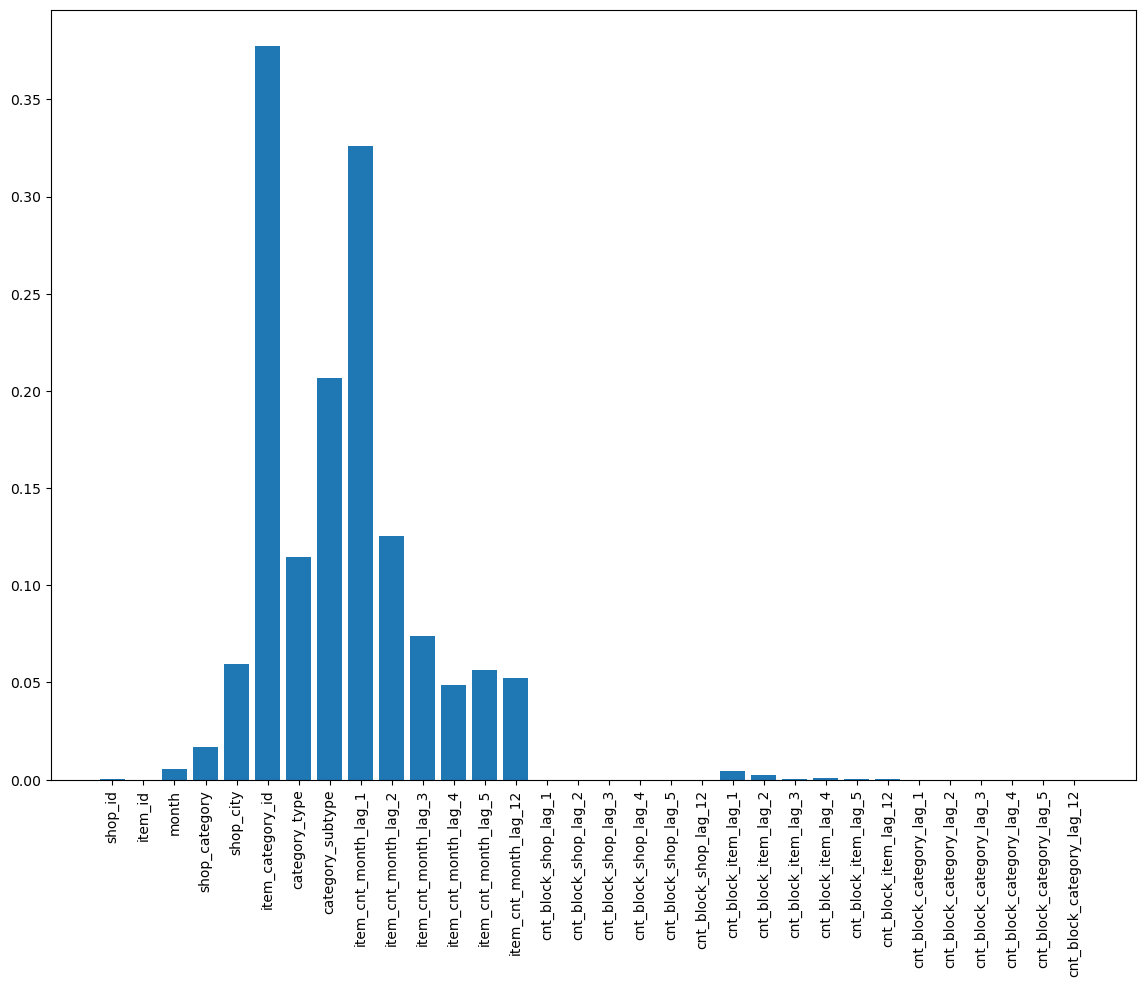

In [106]:
# plot feature importance
importance = lr.coef_
plt.subplots(1,1,figsize=(14,10));
plt.xticks(rotation=90);
plt.bar(list(X_train), abs(importance));

## XGB Regressor Tree

In [ ]:
#  import the required modules for cross-validation and XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [34]:
# Hyper Parameter Tuning
hyper_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9], 
                'gamma': [0, 0.5, 1, 1.5, 2, 5], 
                'subsample': [0.6, 0.7, 0.8, 0.9, 1], 
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                'learning_rate': [0.01, 0.1, 0.2, 0.3],
                'max_bin' : [256, 512, 1024]
               }

splits = [] # CV folds
for block in [25, 26, 27, 28, 29, 30]:
    train_idxs = matrix[matrix.date_block_num < block].index.values
    test_idxs = matrix[matrix.date_block_num == block].index.values
    splits.append((train_idxs, test_idxs))

xgbr = XGBRegressor(seed = 13, tree_method = "hist") 
clf = RandomizedSearchCV(estimator = xgbr, 
                   param_distributions = hyper_params,
                   n_iter = 4, #
                   scoring = 'neg_root_mean_squared_error',
                   cv = splits,
                   verbose=3)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", -clf.best_score_)

[(array([      0,       1,       2, ..., 4244263, 4244264, 4244265]),
  array([4244266, 4244267, 4244268, ..., 4528566, 4528567, 4528568])),
 (array([      0,       1,       2, ..., 4528566, 4528567, 4528568]),
  array([4528569, 4528570, 4528571, ..., 4808154, 4808155, 4808156])),
 (array([      0,       1,       2, ..., 4808154, 4808155, 4808156]),
  array([4808157, 4808158, 4808159, ..., 5054439, 5054440, 5054441])),
 (array([      0,       1,       2, ..., 5054439, 5054440, 5054441]),
  array([5054442, 5054443, 5054444, ..., 5286891, 5286892, 5286893])),
 (array([      0,       1,       2, ..., 5286891, 5286892, 5286893]),
  array([5286894, 5286895, 5286896, ..., 5511007, 5511008, 5511009])),
 (array([      0,       1,       2, ..., 5511007, 5511008, 5511009]),
  array([5511010, 5511011, 5511012, ..., 5739681, 5739682, 5739683]))]

In [43]:
# Traing with the best hyper-parameters

xgb = XGBRegressor(seed = 13, 
    tree_method = "hist", 
    subsample = 0.7,
    max_depth = 9,
    learning_rate = 0.3,
    gamma = 5,
    colsample_bytree = 0.8,
      max_bin=512             
    )
xgb.fit(
    X_train,y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True,
    early_stopping_rounds = 10
    )
yhat_val_xgb = xgb.predict(X_val).clip(0, 20)
print('Valdation RMSE:', mean_squared_error(y_val, yhat_val_xgb, squared=False)) 
#Valdation RMSE: 0.9409594444278176
yhat_test_xgb = xgb.predict(X_test).clip(0, 20)

[0]	validation_0-rmse:1.05478	validation_1-rmse:1.04498
[1]	validation_0-rmse:0.96531	validation_1-rmse:0.99175
[2]	validation_0-rmse:0.91390	validation_1-rmse:0.96635
[3]	validation_0-rmse:0.88357	validation_1-rmse:0.95412
[4]	validation_0-rmse:0.86261	validation_1-rmse:0.95032
[5]	validation_0-rmse:0.84907	validation_1-rmse:0.94800
[6]	validation_0-rmse:0.83926	validation_1-rmse:0.94344
[7]	validation_0-rmse:0.83309	validation_1-rmse:0.94280
[8]	validation_0-rmse:0.82813	validation_1-rmse:0.94291
[9]	validation_0-rmse:0.82341	validation_1-rmse:0.94363
[10]	validation_0-rmse:0.82002	validation_1-rmse:0.94466
[11]	validation_0-rmse:0.81678	validation_1-rmse:0.94456
[12]	validation_0-rmse:0.81305	validation_1-rmse:0.93938
[13]	validation_0-rmse:0.81032	validation_1-rmse:0.94093
[14]	validation_0-rmse:0.80823	validation_1-rmse:0.94046
[15]	validation_0-rmse:0.80638	validation_1-rmse:0.94051
[16]	validation_0-rmse:0.80185	validation_1-rmse:0.94078
[17]	validation_0-rmse:0.79947	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

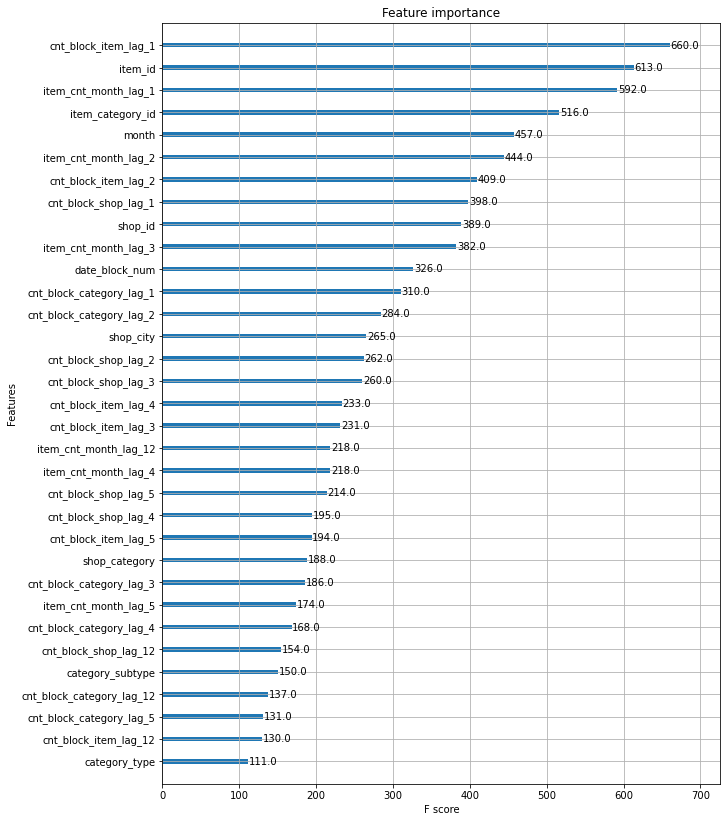

In [44]:
# Visualize the features importance
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(booster=xgb, ax=ax)

## Ensembeling

In [107]:
X_train_meta = [[],[]]

for block in [25, 26, 27, 28, 29, 30]:
    print('Block:', block)
    # X and y Train for blocks from 12 to block
    X_train_block = matrix[matrix.date_block_num < block].drop(['date_block_num', 'item_cnt_month'], axis=1)
    y_train_block = matrix[matrix.date_block_num < block].item_cnt_month
    # X and y Test for block
    X_val_block = matrix[matrix.date_block_num == block].drop(['date_block_num', 'item_cnt_month'], axis=1)
    #y_test_block = matrix[matrix.date_block_num == block].item_cnt_month
    
    # Fit first model 
    print(' LR fitting ...')
    lr.fit(X_train_block, y_train_block)
    print(' LR fitting ... done')
    # Append prediction results on X_val_block to X_train_meta (first column)
    X_train_meta[0] += list(lr.predict(X_val_block).clip(0, 20))
    
    # Fit second model
    print(' XGB fitting ...')
    xgb.fit(
        X_train_block, y_train_block,
        eval_metric="rmse",
        eval_set=[(X_train_block, y_train_block)],
        #eval_set=[(X_train_block, y_train_block), (X_val_block, y_test_block)],
        verbose=0,
        early_stopping_rounds = 10
    )
    print(' XGB fitting ... done')
    # Append prediction results on X_val_block to X_train_meta (second column)
    X_train_meta[1] += list(xgb.predict(X_val_block).clip(0, 20))

# Turn list into dataframe
X_train_meta = pd.DataFrame({'yhat_lr': X_train_meta[0], 'yhat_xgb': X_train_meta[1]})

y_train_meta = matrix[matrix.date_block_num.isin([25, 26, 27, 28, 29, 30])].item_cnt_month

Block: 25
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 26
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 27
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 28
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 29
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done
Block: 30
 LR fitting ...
 LR fitting ... done
 XGB fitting ...
 XGB fitting ... done


## Stacking

In [108]:
stacking = LinearRegression()
stacking.fit(X_train_meta, y_train_meta)

#Squared: If True returns MSE value, if False returns RMSE value.
yhat_train_meta = stacking.predict(X_train_meta).clip(0, 20)
print('Meta Training RMSE:', mean_squared_error(y_train_meta, yhat_train_meta, squared=False))
# Meta Training RMSE: 0.7959949995252207

yhat_val_meta = stacking.predict(np.vstack((yhat_val_lr, yhat_val_xgb)).T).clip(0, 20)
print('Meta Validation RMSE:', mean_squared_error(y_val, yhat_val_meta, squared=False))

# Meta Validation RMSE: 0.9313002364522425

yhat_test_meta = stacking.predict(np.vstack((yhat_test_lr, yhat_test_xgb)).T).clip(0, 20)

Meta Training RMSE: 0.8012416142596269
Meta Validation RMSE: 0.9265275113512034


# Submission

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": yhat_test_meta
})
submission.to_csv('submission_stacking.csv', index=False)